# Week 3: Improve MNIST with Convolutions

In the videos you looked at how you would improve Fashion MNIST using Convolutions. For this exercise see if you can improve MNIST to 99.5% accuracy or more by adding only a single convolutional layer and a single MaxPooling 2D layer to the model from the  assignment of the previous week. 

You should stop training once the accuracy goes above this amount. It should happen in less than 10 epochs, so it's ok to hard code the number of epochs for training, but your training must end once it hits the above metric. If it doesn't, then you'll need to redesign your callback.

When 99.5% accuracy has been hit, you should print out the string "Reached 99.5% accuracy so cancelling training!"


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Load the data

Begin by loading the data. A couple of things to notice:

- The file `mnist.npz` is already included in the current workspace under the `data` directory. By default the `load_data` from Keras accepts a path relative to `~/.keras/datasets` but in this case it is stored somewhere else, as a result of this, you need to specify the full path.

- `load_data` returns the train and test sets in the form of the tuples `(x_train, y_train), (x_test, y_test)` but in this exercise you will be needing only the train set so you can ignore the second tuple.

In [27]:
# Load the data

# Get current working directory
#current_dir = os.getcwd()

# Append data/mnist.npz to the previous path to get the full path
#data_path = os.path.join(current_dir, "data/mnist.npz") 

data_path = r'C:\wagon\code\tensorflow-1-public\data\mnist.npz'

# Get only training set
(training_images, training_labels), (testing_images, testing_labels) = tf.keras.datasets.mnist.load_data(path=data_path) 

9


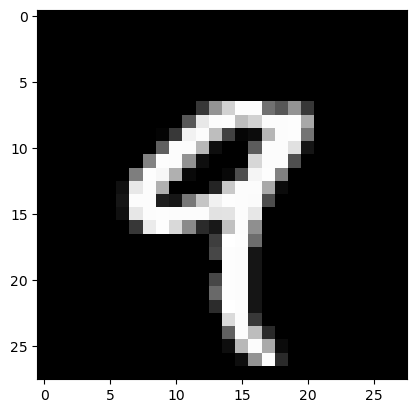

In [28]:
# Plot image example
import matplotlib.pyplot as plt

img_index = 4

print(training_labels[img_index])

plt.gray()
plt.grid(False)
plt.imshow(training_images[img_index])
plt.show()

In [29]:
training_images[232].shape

(28, 28)

In [30]:
training_images[232]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  88, 127,   5,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         19,  58,  20,  14, 217,  19,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7, 146,
        247, 253, 235,  27,  84,  81,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [31]:
len(training_images)

60000

In [32]:
training_images.shape[1]

28

In [33]:
training_images.max()

255

In [40]:
training_images.shape

(60000, 28, 28)

In [39]:
training_images.shape[0]

60000

## Pre-processing the data

One important step when dealing with image data is to preprocess the data. During the preprocess step you can apply transformations to the dataset that will be fed into your convolutional neural network.

Here you will apply two transformations to the data:
- Reshape the data so that it has an extra dimension. The reason for this 
is that commonly you will use 3-dimensional arrays (without counting the batch dimension) to represent image data. The third dimension represents the color using RGB values. This data might be in black and white format so the third dimension doesn't really add any additional information for the classification process but it is a good practice regardless.


- Normalize the pixel values so that these are values between 0 and 1. You can achieve this by dividing every value in the array by the maximum.

Remember that these tensors are of type `numpy.ndarray` so you can use functions like [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) or [divide](https://numpy.org/doc/stable/reference/generated/numpy.divide.html) to complete the `reshape_and_normalize` function below:

In [41]:
# GRADED FUNCTION: reshape_and_normalize

def reshape_and_normalize(images):
    
    ### START CODE HERE

    # Reshape the images to add an extra dimension
    images = images.reshape(images.shape[0], 28, 28, 1)
    
    # Normalize pixel values
    images = images / images.max()
    
    ### END CODE HERE

    return images

Test your function with the next cell:

In [42]:
# Reload the images in case you run this cell multiple times
(training_images, _), _ = tf.keras.datasets.mnist.load_data(path=data_path) 

# Apply your function
training_images = reshape_and_normalize(training_images)

print(f"Maximum pixel value after normalization: {np.max(training_images)}\n")
print(f"Shape of training set after reshaping: {training_images.shape}\n")
print(f"Shape of one image after reshaping: {training_images[0].shape}")


Maximum pixel value after normalization: 1.0

Shape of training set after reshaping: (60000, 28, 28, 1)

Shape of one image after reshaping: (28, 28, 1)


**Expected Output:**
```
Maximum pixel value after normalization: 1.0

Shape of training set after reshaping: (60000, 28, 28, 1)

Shape of one image after reshaping: (28, 28, 1)
```

## Defining your callback

Now complete the callback that will ensure that training will stop after an accuracy of 99.5% is reached:

In [45]:
# GRADED CLASS: myCallback
### START CODE HERE

# Remember to inherit from the correct class
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.995:
            print("\nReached 99.5% accuracy; cancelling training.")

            # Stop training
            self.model.stop_training = True

### END CODE HERE


## Convolutional Model

Finally, complete the `convolutional_model` function below. This function should return your convolutional neural network.

**Your model should achieve an accuracy of 99.5% or more before 10 epochs to pass this assignment.**

**Hints:**
- You can try any architecture for the network but try to keep in mind you don't need a complex one. For instance, only one convolutional layer is needed. 

- In case you need extra help you can check out an architecture that works pretty well at the end of this notebook.

In [51]:
# GRADED FUNCTION: convolutional_model
def convolutional_model():
    ### START CODE HERE

    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ]) 

    ### END CODE HERE

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 
        
    return model

In [52]:
# Save your untrained model
model = convolutional_model()

# Instantiate the callback class
callbacks = myCallback()

# Train your model (this can take up to 5 minutes)
history = model.fit(training_images, training_labels, epochs=10, callbacks=[callbacks])

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1495 - accuracy: 0.9555
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0484 - accuracy: 0.9852
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0315 - accuracy: 0.9905
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0218 - accuracy: 0.9931
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9957
Reached 99.5% accuracy; cancelling training.
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0138 - accuracy: 0.9957


If you see the message that you defined in your callback printed out after less than 10 epochs it means your callback worked as expected. You can also double check by running the following cell:

In [53]:
print(f"Your model was trained for {len(history.epoch)} epochs")

Your model was trained for 5 epochs


In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               692352    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
________________________________________________

In [59]:
from tensorflow.keras.callbacks import TensorBoard

# Add TensorBoard callback
log_dir = './logs'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train your model (this can take up to 5 minutes)
history = model.fit(training_images, training_labels, epochs=10, 
                    callbacks=[tensorboard_callback])

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0076 - accuracy: 0.9974
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0061 - accuracy: 0.9980
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0041 - accuracy: 0.9987
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0050 - accuracy: 0.9982
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0032 - accuracy: 0.9990
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0038 - accuracy: 0.9988
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0034 - accuracy: 0.9990
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0032 - accuracy: 0.9990
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0027 - accuracy: 0.9991
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.002

In [60]:
# Launch TensorBoard in the notebook
%load_ext tensorboard
%tensorboard --logdir ./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 27184), started 0:02:56 ago. (Use '!kill 27184' to kill it.)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
model.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[tensorboard_callback])

# Launch TensorBoard in the notebook
%load_ext tensorboard
%tensorboard --logdir ./logs


## Need more help?

Run the following cell to see an architecture that works well for the problem at hand:

In [48]:
# WE STRONGLY RECOMMEND YOU TO TRY YOUR OWN ARCHITECTURES FIRST
# AND ONLY RUN THIS CELL IF YOU WISH TO SEE AN ANSWER

import base64

encoded_answer = "CiAgIC0gQSBDb252MkQgbGF5ZXIgd2l0aCAzMiBmaWx0ZXJzLCBhIGtlcm5lbF9zaXplIG9mIDN4MywgUmVMVSBhY3RpdmF0aW9uIGZ1bmN0aW9uIGFuZCBhbiBpbnB1dCBzaGFwZSB0aGF0IG1hdGNoZXMgdGhhdCBvZiBldmVyeSBpbWFnZSBpbiB0aGUgdHJhaW5pbmcgc2V0CiAgIC0gQSBNYXhQb29saW5nMkQgbGF5ZXIgd2l0aCBhIHBvb2xfc2l6ZSBvZiAyeDIKICAgLSBBIEZsYXR0ZW4gbGF5ZXIgd2l0aCBubyBhcmd1bWVudHMKICAgLSBBIERlbnNlIGxheWVyIHdpdGggMTI4IHVuaXRzIGFuZCBSZUxVIGFjdGl2YXRpb24gZnVuY3Rpb24KICAgLSBBIERlbnNlIGxheWVyIHdpdGggMTAgdW5pdHMgYW5kIHNvZnRtYXggYWN0aXZhdGlvbiBmdW5jdGlvbgo="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


   - A Conv2D layer with 32 filters, a kernel_size of 3x3, ReLU activation function and an input shape that matches that of every image in the training set
   - A MaxPooling2D layer with a pool_size of 2x2
   - A Flatten layer with no arguments
   - A Dense layer with 128 units and ReLU activation function
   - A Dense layer with 10 units and softmax activation function



**Congratulations on finishing this week's assignment!**

You have successfully implemented a CNN to assist you in the image classification task. Nice job!

**Keep it up!**